In [1]:
#Import modules
#common
import os
import keras
from tqdm import tqdm
from glob import glob
import tensorflow as tf
from numpy import zeros
from numpy.random import randint
from PIL import Image, ImageOps
import PIL.ExifTags
import matplotlib.pyplot as plt

# Data
from tensorflow.image import resize
from keras.preprocessing.image import load_img, img_to_array

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.layers import add
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import multiply
from keras.layers import concatenate
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout

# Model Functions
from keras.callbacks import EarlyStopping
from keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.utils import register_keras_serializable

#Defining a function to show the images
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

#Defining a function to load in the images and convert to arrays
def load_image(path):
    img = load_img(path)
    img = ImageOps.exif_transpose(img)
    img = resize(img_to_array(img)/255., (224,224))
    return img

#Defining a function to load in the data
def load_data(paths):
    images = zeros(shape=(len(paths), 224,224,3))
    for i, path in tqdm(enumerate(paths), desc="Loading"):
        image = load_image(path)
        images[i] = image
    return images

#Setting up the model structure (encoder and decoder classes)
#Encoder
@register_keras_serializable()
class Encoder(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(Encoder, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.bn = BatchNormalization()
        self.c1 = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.bn(X)
        x = self.c1(x)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }
#Decoder
@register_keras_serializable()
class Decoder(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.bn = BatchNormalization()
        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer="he_normal")
        self.net = Encoder(filters, rate, pooling=False)

    def call(self, X):
        x, skip_x = X
        x = self.bn(x)
        x = self.cT(x)
        x = concatenate([x, skip_x])
        x = self.net(x)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "rate":self.rate,
        }



2025-11-30 22:44:23.347706: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-30 22:44:23.348599: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 22:44:23.437675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 22:44:25.163934: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Total Number of Images : 8


Loading: 4it [00:00, 28.89it/s]
2025-11-30 22:44:53.064422: I external/local_xla/xla/service/service.cc:163] XLA service 0x76b6340181f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-11-30 22:44:53.064464: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-11-30 22:44:53.081199: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764542693.347623    2658 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


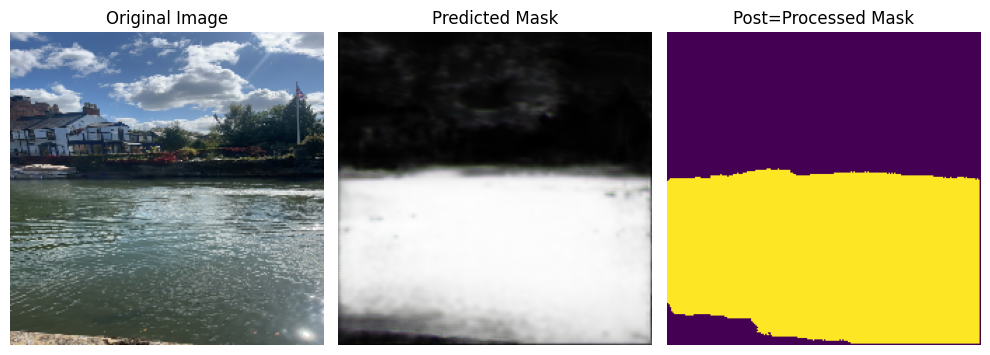

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


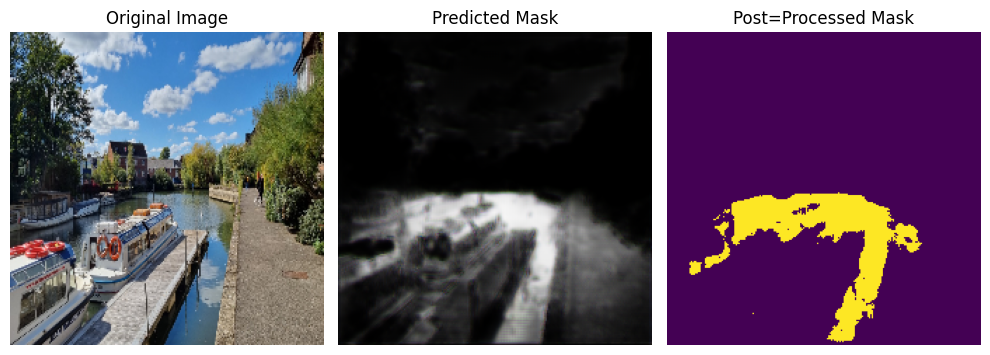

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


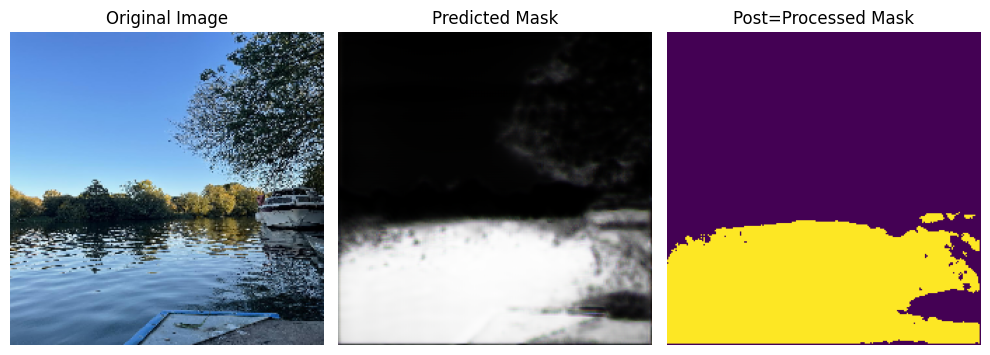

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


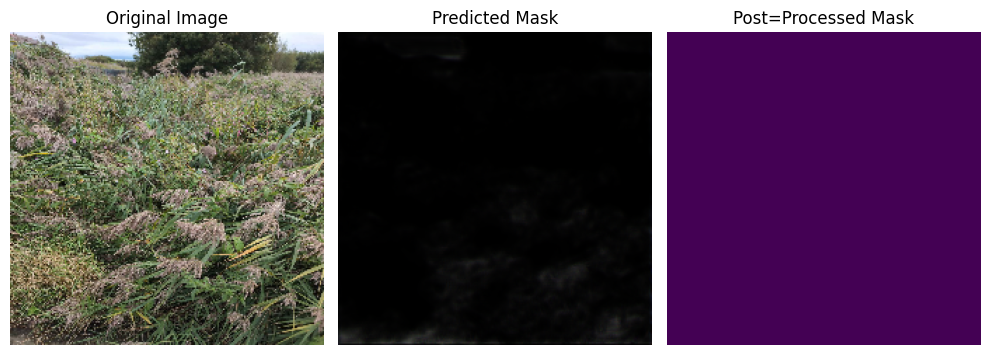

In [3]:
#Load the best model
UNet = tf.keras.models.load_model(
    "UNet_best_bs8.keras",
    custom_objects={"Encoder": Encoder, "Decoder": Decoder},
    compile=True   
)

#Set the path where the photos are
my_image_path="our_images"
total_images = len(os.listdir(my_image_path))
print(f"Total Number of Images : {total_images}")
my_paths=sorted(glob(my_image_path + "/*.jpg"))
n_files=len(my_paths)

#Load in the images
X_values = load_data(my_paths)

#Run through all the images
for i in range(n_files):
    id = i
    image = X_values[id]
    pred_mask = UNet.predict(tf.expand_dims(image,axis=0))[0]
    post_process = (pred_mask[:,:,0] > 0.5).astype('int')

    plt.figure(figsize=(10,8))
    plt.subplot(1,3,1)
    show_image(image, title="Original Image")

    plt.subplot(1,3,2)
    show_image(pred_mask, title="Predicted Mask")

    plt.subplot(1,3,3)
    show_image(post_process, title="Post=Processed Mask")

    plt.tight_layout()
    plt.show()